## MOEA


### Toy tracker problem

This section outlines the toy Problem that is used for the hands-on session through out the lectures with the goal to introduce optimization technique and useful frameworks in python.

### Problem Statement

Consider a toy wire based tracker. the toy wire based tracker consists in a 2D tracking system with of 4 layers of wires along `z`.

![Toy Tracker Problem](https://aid2e.github.io/boot-camp-2024/_images/toy_tracker.png)


A total of 8 parameters can be tuned. The adjustable parameters are the radius of the wire, the pitch (along the y-axis), and the shift along y and z of a plane with respect to the previous one.


Straight tracks are generated at different angles and random origin. The tracker geometry and random origin. The tracker geometry and the tracker generation is already defined in the imported module [detector.py](https://raw.githubusercontent.com/cfteach/modules/master/detector2.py)


### Objectives

One can evaluate the performance of the tracker on multiple metrics. These are are refered to as `objectives`. In the following lectures, the `objectives` against which the performance of the tracker will be evaulated are,

* Efficiency - Defined as the fraction of tracks that has atleast 2 wires hit in the event.

* Volume - Volume occupied by the tracking system. This is a proxy for the cost of the tracker.

* Resolution - Resolution extracted from the tracks.

In [ ]:
import warnings; warnings.simplefilter('ignore')

In [ ]:
!wget https://raw.githubusercontent.com/cfteach/modules/master/detector2.py
!pip install pymoo > /dev/null 2>&1
!pip install plotly > /dev/null 2>&1
!pip install ipyvolume > /dev/null 2>&1
!pip install altair > /dev/null 2>&1

--2025-06-08 17:04:39--  https://raw.githubusercontent.com/cfteach/modules/master/detector2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7976 (7.8K) [text/plain]
Saving to: ‘detector2.py’

detector2.py        100%[===================>]   7.79K  --.-KB/s    in 0s      

2025-06-08 17:04:39 (93.4 MB/s) - ‘detector2.py’ saved [7976/7976]



In [ ]:
%load_ext autoreload
%autoreload 2


import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import AI4NP_detector_opt.sol2.detector2 as detector2
import detector2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.util.display.column import Column
from pymoo.util.display.output import Output

from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting


### Create detector geometry and simulate tracks

The module detector creates a simple 2D geometry of a wire based tracker made by 4 planes.

The adjustable parameters are the radius of each wire, the pitch (along the y axis), and the shift along y and z of a plane with respect to the previous one.

A total of 8 parameters can be tuned.

The goal of this toy model, is to tune the detector design so to optimize the efficiency (fraction of tracks which are detected) as well as the cost for its realization. As a proxy for the cost, we use the material/volume (the surface in 2D) of the detector. For a track to be detetected, in the efficiency definition we require at least two wires hit by the track.

So we want to maximize the efficiency (defined in detector.py) and minimize the cost.

#### LIST OF PARAMETERS
(baseline values)
* R = .5   [cm]
* pitch = 4.0  [cm]
* y1 = 0.0, y2 = 0.0, y3 = 0.0, z1 = 2.0, z2 = 4.0, z3 = 6.0 [cm]


::::: BASELINE PARAMETERS :::::
R, pitch, y1, y2, y3, z1, z2, z3:  0.5 4.0 2.0 1.0 0.0 2.0 4.0 6.0 

:::: INITIAL GEOMETRY ::::
# of wires:  21 , volume:  65.94
:::: TRACK GENERATION ::::


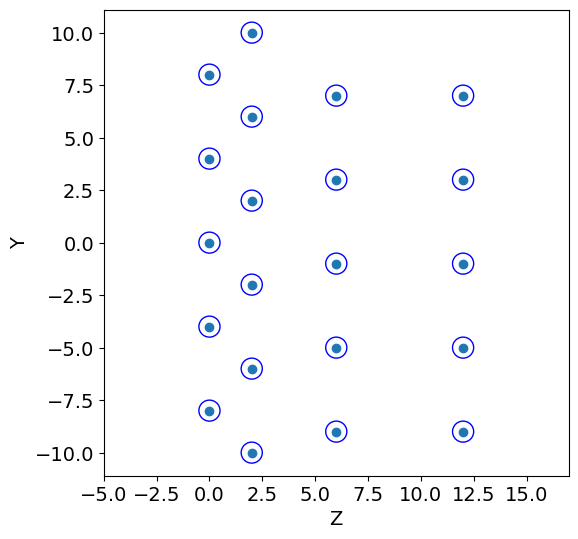

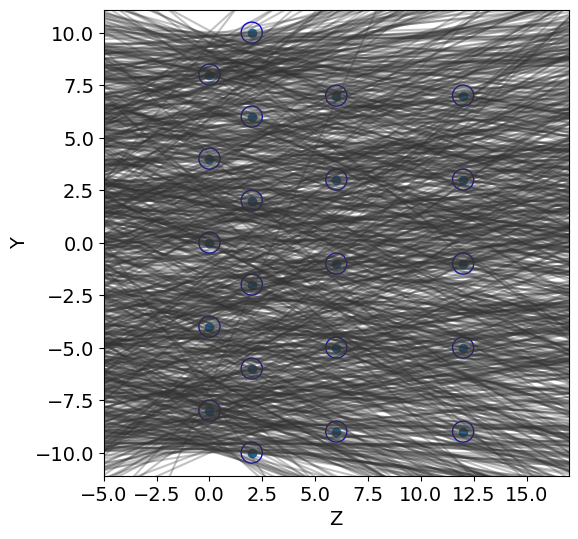

fraction of tracks detected:  0.259
resolution:  0.2405574316639721


In [ ]:
# CONSTANT PARAMETERS
#------ define mother region ------#
y_min=-10.1
y_max=10.1
N_tracks = 1000


print("::::: BASELINE PARAMETERS :::::")
R = 0.5
pitch = 4.0
y1 = 2.0
y2 = 1.0
y3 = 0.0
z1 = 2.0
z2 = 4.0
z3 = 6.0

print("R, pitch, y1, y2, y3, z1, z2, z3: ", R, pitch, y1, y2, y3, z1, z2, z3,"\n")


#------------- GEOMETRY ---------------#
print(":::: INITIAL GEOMETRY ::::")
tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
Z, Y = tr.create_geometry()
num_wires = detector2.calculate_wires(Y, y_min, y_max)

volume = detector2.wires_volume(Y, y_min, y_max,R)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False,pause=5) #5

print("# of wires: ", num_wires, ", volume: ", volume)

#------------- TRACK GENERATION -----------#
print(":::: TRACK GENERATION ::::")
t = detector2.Tracks(b_min=y_min, b_max=y_max, alpha_mean=0, alpha_std=0.3)
tracks = t.generate(N_tracks)

detector2.geometry_display(Z, Y, R, y_min=y_min, y_max=y_max,block=False, pause=-1)
detector2.tracks_display(tracks, Z,block=False,pause=-1)

 #a track is detected if at least two wires have been hit
score = detector2.get_score(Z, Y, tracks, R)
frac_detected = score[0]
resolution = score[1]
print("fraction of tracks detected: ",frac_detected)
print("resolution: ",resolution)

---

### Define Objectives



Defines a class for the objectives of the problem that can be used in the MOO.

In [ ]:
# The objectives are computed by setting up the geometry and
# computing the values of the objectives. Mimicing a G4 type simulation
class objectives():

  def __init__(self,tracks,y_min,y_max):
    self.tracks = tracks
    self.y_min = y_min
    self.y_max = y_max

  def wrapper_geometry(fun):

      def inner(self):
          R, pitch, y1, y2, y3, z1, z2, z3 = self.X
          self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
          return fun(self)
      return inner

  def update_tracks(self, new_tracks):
    self.tracks = new_tracks

  def update_design_point(self,X):
      self.X = X


  def geometry(self,R, pitch, y1, y2, y3, z1, z2, z3):
    tr = detector2.Tracker(R, pitch, y1, y2, y3, z1, z2, z3)
    self.R = R
    self.Z, self.Y = tr.create_geometry()


  @wrapper_geometry
  def calc_score(self):
      res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
      assert res[0] >= 0 and res[1] >= 0,"Fraction or Resolution negative."

      return res


  def get_score(self,X):
    R, pitch, y1, y2, y3, z1, z2, z3 = X
    self.geometry(R, pitch, y1, y2, y3, z1, z2, z3)
    res = detector2.get_score(self.Z, self.Y, self.tracks, self.R)
    return res


  def get_volume(self):
    volume = detector2.wires_volume(self.Y, self.y_min, self.y_max,self.R)
    return volume



res = objectives(tracks,y_min,y_max)

#res.geometry(R, pitch, y1, y2, y3, z1, z2, z3)

X = R, pitch, y1, y2, y3, z1, z2, z3
#fscore  = res.get_score(X)
res.update_design_point(X)
fscore  = res.calc_score()[0]
fvolume = res.get_volume()

print("...check: ", fvolume, fscore)


...check:  65.94 0.259


---
### Multi-Objective Optimization

We will be using pymoo (https://pymoo.org/getting_started.html).

* In the constructor method we specify number of variables N, objectives M, and constraint functions, as well as the lower and upper boundaries of each variable. In our toy model, these boundaries are taken in such a way that all solutions are feasible and no constraint function is needed. You can try to change this and introduce some constraint.



* The *_evaluate* method takes a one-dimensional NumPy array x number of entries equal to n_var. This behavior is enabled by setting *elementwise_evaluation=True* while calling the super() method.

* Notice that every function is minimized. Our efficiency is defined as an tracking inefficiency = 1 - efficiency

* We add the resolution as a third objective.  The average residual of the track hit from the wire centre is used as a proxy for the resolution for this toy-model




In [ ]:
from pymoo.core.problem import ElementwiseProblem
class MyProblem(ElementwiseProblem):

    #--------- vectorized ---------#

    def __init__(self, n_var=8, n_obj=2, n_constr=0,
                 xl=np.array([0.5,2.5,0.,0.,0.,2.,2.,2.]),
                 xu=np.array([1.0,5.0,4.,4.,4.,10.,10.,10.])
                 ):
        super().__init__(n_var=n_var, n_obj=n_obj, n_constr=n_constr, xl=xl, xu=xu)

    def _evaluate(self, x, out, *args, **kwargs):


        f1 = 1.- res.get_score(x)[0] # Ineffiency
        f2 = res.get_volume() # volume
        #f3 = res.get_score(x)[1] #resolution

        out["F"] = [f1, f2]#, f3]




### Creation of Problem and choice of optimization algorithm.


* We will use NSGA-II, as explained in the lectures. You can decide the population size and the number of offsprings, based on what we discussed.


* Pymoo offers different algorithms that can be used which are highly customizable and can be easily extended.
https://pymoo.org/algorithms/index.html


* Before dealing with a problem, it's useful to compare with a list of test problems reported in https://pymoo.org/problems/index.html, where different scenarios in terms of Variables, Objectives, Constraints are described.



In [ ]:
n_var = 8 # number of design variables
n_obj = 2 # number of objectives
n_constr = 0 # number of constraints
xl = np.array([0.5,2.5,0.,0.,0.,2.,2.,2.]) # lower bounds of the problem, pitch, diameter, y1, y2, y3, z1, z2, z3
xu = np.array([1.0,5.0,4.,4.,4.,10.,10.,10.]) # upper bounds of the problem, pitch, diameter, y1, y2, y3, z1, z2, z3
pop_size = 40
n_offsprings=10

problem = MyProblem(n_var=n_var, n_obj=n_obj, n_constr=n_constr, xl=xl, xu=xu)



from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.termination.xtol import DesignSpaceTermination
from pymoo.termination.robust import RobustTermination


# check out other sampling methods here https://pymoo.org/operators/sampling.html
# check out other crossover methods here https://pymoo.org/operators/crossover.html

algorithm = NSGA2(pop_size=pop_size,n_offsprings=10)
crossover = SBX(prob=1.0, eta=1)
mutation = PM(eta=1)
termination = RobustTermination(DesignSpaceTermination(tol=0.01), period=20)
res = minimize(problem,
               algorithm,
               crossover = crossover,
               mutation = mutation,
               termination = termination,
               verbose=True,
               seed=1,
               save_history=True # Saves all of the history of the algorithm
               )

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |     11 |             - |             -
     2 |       50 |     13 |  0.0871021776 |         ideal
     3 |       60 |     16 |  0.1372832370 |         ideal
     4 |       70 |     17 |  0.0034332054 |             f
     5 |       80 |     19 |  0.0138353295 |             f
     6 |       90 |     19 |  0.0093112237 |             f
     7 |      100 |     21 |  0.0101346341 |             f
     8 |      110 |     24 |  0.0029376102 |             f
     9 |      120 |     26 |  0.0212164074 |         ideal
    10 |      130 |     30 |  0.0048070233 |             f
    11 |      140 |     34 |  0.0037747897 |             f
    12 |      150 |     35 |  0.0261707989 |         ideal
    13 |      160 |     35 |  0.0081967213 |         ideal
    14 |      170 |     36 |  0.0042495998 |             f
    15 |      180 |     35 |  0.0025737781 |         ideal
    16 |      190 |     35 |  0.0055096419 |         nad

In [ ]:
#print(res.history[0].pop.get("F"))

### Analysis of Results


In [ ]:
import plotly.express as px

fig = px.scatter(res.F, x=0, y=1, labels={'0': 'Efficiency', '1': 'Volume'},
                    title="In Efficiency vs Volume",
                    width=800, height=800)
fig.update_traces(marker=dict(size=8,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                    selector=dict(mode='markers'))
fig.show()

In [ ]:
# Making a animation of evolution
import pandas as pd
import plotly.express as px
obj1 = []
obj2 = []
calls = []
for r in res.history:

    objs = r.pop.get("F")
    obj1.extend(objs[:, 0])
    obj2.extend(objs[:, 1])
    calls.extend([r.n_gen]*len(objs))
df = pd.DataFrame(data = {"InEfficiency": obj1, "Volume": obj2, "n_gen": calls})

obj_fig = px.scatter(df, x="InEfficiency", y="Volume",
                        animation_frame="n_gen", color="n_gen",
                        range_x=[0., 0.6], range_y=[0. , 400.],
                        hover_data = df.columns,
                        width = 800, height = 800)
obj_fig.update(layout_coloraxis_showscale=False)
obj_fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 10
obj_fig.update_layout(transition = {'duration': 0.001})
obj_fig.show()

In [ ]:
# Computing hyper volume


## Tracking hypervolume

from pymoo.indicators.hv import HV
import plotly.graph_objs as go
ref_point = np.array([0.8, 350.0])

hv_list = []

for gen in res.history:
    hv = HV(ref_point)(gen.pop.get("F"))
    hv_list.append(hv)

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(1, len(hv_list)+1), y=hv_list, mode='lines+markers'))
fig.update_layout(title='Hypervolume Tracking', xaxis_title='Generation', yaxis_title='Hypervolume')

fig.show()

print ("Hypervolume at the end of the optimization: ", hv_list[-1])


Hypervolume at the end of the optimization:  179.7466732835622


In [ ]:
# A parallel plot of design adn objective space

import plotly.graph_objects as go

X = res.pop.get("X")
F = res.pop.get("F")

fig = go.Figure(data=go.Parcoords(
    line=dict(color=F[:, 0],
          colorscale='Viridis',
          showscale=True,
          reversescale=True),
    dimensions = [dict(range = [xl[index], xu[index]], label = f'X{index}', values=X[:, index])
    for index in range(len(xl))
    ]
    ))
fig.update_layout(title = "Parallel plot of design space and objective space",
                  template='plotly_dark')
fig.show()


In [ ]:

fig = go.Figure(data=go.Parcoords(
    line=dict(color=F[:, 1],
          colorscale='Viridis',
          showscale=True,
          reversescale=True),
    dimensions = [dict(range = [xl[index], xu[index]], label = f'X{index}', values=X[:, index])
    for index in range(len(xl))
    ]
    ))
fig.update_layout(title = "Parallel plot of design space and objective space",
                  template='plotly_dark')
fig.show()

---

### Exercise


- Can you plot the hypervolume metric to see if the convergence is reached
- Can you implement a termination criterion
- Plot the optimal configuration of the tracker corresponding to that point
- Do analysis of convergence
- Visualize the point with a radar or petal diagram, following https://pymoo.org/visualization/index.html


